<a href="https://colab.research.google.com/github/NitinVerma2027/PRML-Apr2025/blob/main/ml_ipynb_files/knn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, accuracy_score
import random


Downloading...
From (original): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87
From (redirected): https://drive.google.com/uc?id=1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87&confirm=t&uuid=a0ea5715-f14b-49ef-9bd5-bd6dabc986ca
To: /content/train_dataset.csv
100%|██████████| 110M/110M [00:00<00:00, 115MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy
To: /content/test_dataset.csv
100%|██████████| 18.3M/18.3M [00:00<00:00, 75.3MB/s]


Training Data Shape: (60000, 784)
Testing Data Shape: (10000, 784)


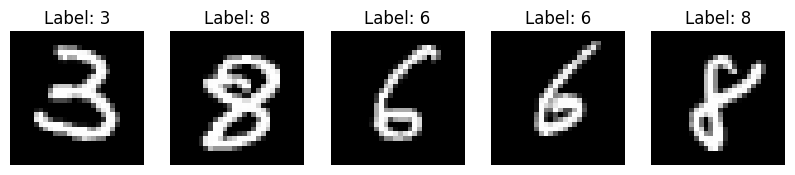

In [3]:
# Download dataset
train_file_id = "1gj1rEzLDzNBpRswfqZaJxCFs5EwQSA87"
test_file_id = "1MX9ckuU6rhL3PaVvflrXsZ-0m2bFeWsy"

train_url = f"https://drive.google.com/uc?id={train_file_id}"
test_url = f"https://drive.google.com/uc?id={test_file_id}"

train_output = "train_dataset.csv"
test_output = "test_dataset.csv"

gdown.download(train_url, train_output, quiet=False)
gdown.download(test_url, test_output, quiet=False)

# Load Data
train_df = pd.read_csv(train_output, header=None)
test_df = pd.read_csv(test_output, header=None)

# Extract Features & Labels
y_train = train_df.iloc[:, 0].values  # Labels
X_train = train_df.iloc[:, 1:].values / 255.0  # Normalize Features

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values / 255.0

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

# Display Sample Images (with random selection)
num_samples = 5  # Number of samples to display
sample_indices = random.sample(range(len(X_train)), num_samples)  # Get random indices

fig, axes = plt.subplots(1, num_samples, figsize=(10, 3))
for i, ax in enumerate(axes):
    index = sample_indices[i]  # Get the random index
    ax.imshow(X_train[index].reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {y_train[index]}")
    ax.axis("off")
plt.show()
